# Introduction

This challenge serves as final project for the "How to win a data science competition" Coursera course. Unfortunately this course have been removed from Coursera now.
In this competition we need to predict total sales for every product and store in the next month. Its challenging time-series dataset consisting of daily sales data, provided by one of the largest Russian software firms - **1C Company**.
           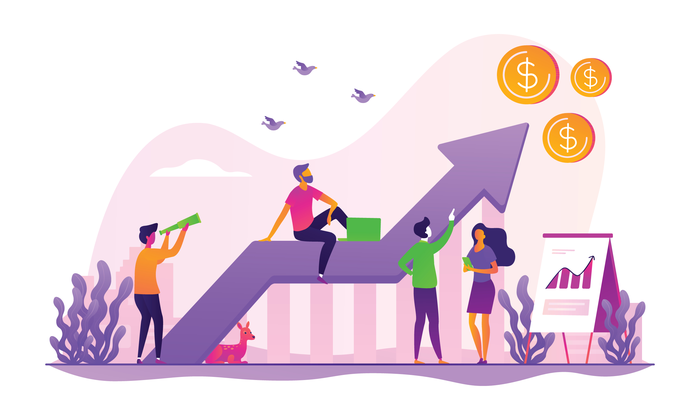 


**Files detail**: We have been provided below list of files,
1. **sales_train**: the training set. Daily historical data from January 2013 to October 2015.
1. **test**: the test set. You need to forecast the sales for these shops and products for November 2015.
1. **items**: supplemental information about the items/products.
1. **item_categories**: supplemental information about the items categories.
1. **shops**: supplemental information about the shops.

**Data fields**:

1. **ID**: an Id that represents a (Shop, Item) tuple within the test set
1. **shop_id**: unique identifier of a shop
1. **item_id**: unique identifier of a product
1. **item_category_id**: unique identifier of item category
1. **item_cnt_day**: number of products sold. You are predicting a monthly amount of this measure
1. **item_price**: current price of an item
1. **date**: date in format dd/mm/yyyy
1. **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
1. **item_name**: name of item
1. **shop_name**: name of shop
1. **item_category_name**: name of item category

# Data Extraction

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline 

import tensorflow as tf
from sklearn import preprocessing

import random
tf.random.set_seed(53)
random.seed(53)

In [ ]:
BASE="../input/competitive-data-science-predict-future-sales/"
item_cat = pd.read_csv(BASE+"item_categories.csv")
item = pd.read_csv(BASE+"items.csv")
sales_train = pd.read_csv(BASE+"sales_train.csv")
shops = pd.read_csv(BASE+"shops.csv")
sales_test = pd.read_csv(BASE+"test.csv")

In [ ]:
def basic_eda(df):
    print("----------TOP 5 RECORDS--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)

In [ ]:
print("=============================Sales Data=============================")
basic_eda(sales_train)

In [ ]:
print("=============================Test data=============================")
basic_eda(sales_test)

In [ ]:
print("=============================Item Categories=============================")
basic_eda(item_cat)

In [ ]:
print("=============================Items=============================")
basic_eda(item)

In [ ]:
print("=============================Shops=============================")
basic_eda(shops)

# EDA

In [ ]:
corr = sales_train.corr()
top_corr_features = corr.index[abs(corr["item_cnt_day"])>0]

plt.figure(figsize=(6,6))
g=sns.heatmap(sales_train[top_corr_features].corr(),annot=True,cmap="YlGnBu")

In [ ]:
sns.set(rc={'figure.figsize':(15,6)})
sns.boxplot(x='shop_id', y='item_cnt_day', data=sales_train)

In [ ]:
sns.set(rc={'figure.figsize':(15,6)})
sns.boxplot(x='date_block_num', y='item_cnt_day', data=sales_train)

In [ ]:
plt.scatter(sales_train['item_price'], sales_train['item_cnt_day'], color = "red")
plt.show()

In [ ]:
df = sales_train.groupby(['date_block_num'],as_index=False).sum()
df.head()
sns.set(rc={'figure.figsize':(15,6)})
sns.lineplot(x='date_block_num', y='item_cnt_day', data=df)
plt.axvline(x=11, ymin=0,ymax=1, color ='r')
plt.axvline(x=23, ymin=0,ymax=1, color ='r')

In [ ]:
df_s = sales_train.groupby(['shop_id'],as_index=False).sum().sort_values("item_cnt_day", ascending=False)
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x='shop_id', y='item_cnt_day', data=df_s)

In [ ]:
df_p = sales_train.groupby(['item_price'],as_index=False).sum()
sns.set(rc={'figure.figsize':(15,6)})
sns.lineplot(x='item_price', y='item_cnt_day', data=df_p)

# Feature Engineering

Lets start removing outliers first.

In [ ]:
sales_train = sales_train[sales_train['item_price'] < 50000]

In [ ]:
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

In [ ]:
print(sum(item.duplicated(['item_name'])))
print(sum(item_cat.duplicated(['item_category_name'])))
print(sum(shops.duplicated(['shop_name'])))

In [ ]:
new_shop_id = {11: 10, 0: 57, 1: 58}
shops['shop_id'] = shops['shop_id'].apply(lambda x: new_shop_id[x] if x in new_shop_id.keys() else x)
sales_train['shop_id'] = sales_train['shop_id'].apply(lambda x: new_shop_id[x] if x in new_shop_id.keys() else x)

In [ ]:
sales = pd.merge(sales_test, sales_train, on = ('shop_id', 'item_id'), how = 'left')

In [ ]:
def missing_percent_of_column(train_set):
    nan_percent = 100*(train_set.isnull().sum()/len(train_set))
    nan_percent = nan_percent[nan_percent>0].sort_values(ascending=False).round(1)
    DataFrame = pd.DataFrame(nan_percent)
    # Rename the columns
    mis_percent_table = DataFrame.rename(columns = {0 : '% of Misiing Values'}) 
    # Sort the table by percentage of missing descending
    mis_percent = mis_percent_table
    return mis_percent

In [ ]:
print('Missing sales details:')
miss_sales = missing_percent_of_column(sales)
miss_sales

In [ ]:
# lets fill all NaN values with 0
sales.fillna(0,inplace = True)
# lets check our data now 
sales.head()

In [ ]:
sales.shape

In [ ]:
print(sum(sales.duplicated()))

We have duplicate records added after merging data, so we are handling duplicate record below way,
1. Remove all duplicate records for all column level.
1. We will take column **date, date_block_num, shop_id, item_id, item_cnt_day** as unique records, and delete duplicate records.
1. Now lets take column **ID, date, date_block_num** as unique also, and delete duplicate records.

In [ ]:
sales = sales.drop_duplicates()
sales = sales.drop_duplicates(['date','date_block_num','shop_id','item_id','item_cnt_day'])
sales = sales.drop_duplicates(['ID','date','date_block_num'])
sales.shape

In [ ]:
sales.describe()

In [ ]:
sales.loc[sales.item_cnt_day < 0, 'item_cnt_day'] = -1. * sales.loc[sales.item_cnt_day < 0, 'item_cnt_day']

In [ ]:
sales_month = sales.sort_values('date_block_num').groupby(['ID', 'date_block_num'], as_index = False).agg({'item_cnt_day': ['sum']})
sales_month.columns = ['ID', 'date_block_num', 'item_cnt_month']
sales_month.sample(10)

In [ ]:
sales_month.describe()

In [ ]:
def to_IDs(np_data, col_ID):
    # np_data - sales converted to numpy array
    # col_ID - name of ID column
    sales_by_ID = list()
    IDs = np.unique(np_data[:,col_ID]).astype(int)
    for i in IDs:
        positions = np_data[:,col_ID] == i
        sales_ID = np_data[positions,1:]
        sales_by_ID.append(sales_ID)
    return sales_by_ID, IDs

In [ ]:
sales_by_id, id_list = to_IDs(sales_month.values,0)
print(len(sales_by_id))

In [ ]:
# to decrease calculation time during a code debugging we remove IDs that don't have observtions for last months
def remove_ID_nan_last_year(np_data):
    N_IDs = len(np_data)
    col_date = 0
    clear_data = list()
    cut_month = 33 - 2
    for i in range(N_IDs):
        ID_data = np_data[i]
        if len(ID_data[ID_data[:,col_date] >= cut_month,1]) != 0:
            clear_data.append(ID_data)
    return clear_data

In [ ]:
# Let's fill the missing date_block_num by NaN for paticular ID
def missing_months(np_data, col_date, col_TS, N_months = 34):
    # col_date - index of date_block_num column
    # col_TS - index of item_price column and item_cnt_month column
    # at first fill time series by NaN for all months
    series = [np.nan for _ in range(N_months)]
    for i in range(len(np_data)):
        position = int(np_data[i, col_date] - 1)
        # fill positions that present in data
        series[position] = np_data[i, col_TS]
    return series

In [ ]:
# Let's fill the missing item_cnt_month and item_price for particular ID
def to_fill_missing(np_data, N_months = 34):
    col = ['date_block_num','item_cnt_month']
    sales_ID = pd.DataFrame(np_data, columns = col)
    if sales_ID.shape[0] < N_months:
        date_month = pd.DataFrame(range(N_months),columns = ['date_block_num'])
        sales_ID = pd.merge(date_month, sales_ID, on = ('date_block_num'), how = 'left')
        sales_ID = sales_ID.reindex(columns = col)
        sales_ID['item_cnt_month'] = sales_ID['item_cnt_month'].fillna(0.0)
    return sales_ID['item_cnt_month'].to_numpy()

In [ ]:
# Plot time series for particular ID to find out missing months
def plot_TS(np_data, n_vars = 1, N_months = 34, flag = 0):
    # n_vars = 1 or 2 (plot item_cnt OR item_cnt and item_price)
    plt.figure()
    if flag == 1:
        TSs = to_fill_missing(np_data, N_months)
    for i in range(n_vars):
        col_plot = i + 1 # index of column to plot
        if flag == 1:
            series = TSs#[:,col_plot]
        else:
            series = missing_months(np_data, 0, col_plot, N_months)
        ax = plt.subplot(n_vars, 1, i+1)
        plt.plot(series, 'o')
        plt.plot(series)
    plt.show()

In [ ]:
for i in np.random.randint(0, len(sales_by_id), 5):
    plot_TS(sales_by_id[i], flag = 1)

In [ ]:
# Let's create 2D-array and each column is counts of particular ID where missing months is filled
def full_data(data, N_months = 34):
    N_IDs = len(data)
    TS = np.empty((N_months, N_IDs))
    for i in range(N_IDs):
        TS[:, i] = to_fill_missing(data[i], N_months)
    return TS

In [ ]:
TS = full_data(sales_by_id)
TS.shape

In [ ]:
val_month = 29
valid_TS = TS[val_month:,:]
train_TS = TS[:val_month,:]

print(train_TS.shape, valid_TS.shape)

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(TS)

train_scaled = scaler.transform(train_TS)
valid_scaled = scaler.transform(valid_TS)

# Model Training

In [ ]:
def to_make_features(TS, n_lag, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(TS) # each element of dataset is one value of TS 
    ds = ds.window(n_lag+1, shift = 1, drop_remainder = True) # (n_lag+1)-elements of dataset is combined to window
    ds = ds.flat_map(lambda row: row.batch(n_lag + 1)) # to batch elements in window to tensor (one element) and to flat (now there are no windows)
    # Let's shuffle befor we combine batches for epoch
    ds = ds.shuffle(300)
    # make the tuple: first element is features, second element is labels
    # features-(1,2,3) and labels-(2,3,4). 2 goes after 1, 3 goes after 2, 4 goes after 3.
    ds = ds.map(lambda row: (row[:-1,:], row[1:,:]))
    # combine tuples to banch for gradient descent
    # instead of a row we will have a matrix in every tuple
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [ ]:
n_lag = 6
batch_size = 8
features = to_make_features(train_scaled, n_lag, batch_size)
val_features = to_make_features(valid_scaled, n_lag, batch_size)
Conv_filters = 64
Conv_kernel_size = 4
LSTM_filters = 64
n_outputs = train_scaled.shape[1]

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = Conv_filters, kernel_size = Conv_kernel_size,
                      strides=1, padding="causal", activation="relu", input_shape=[None, n_outputs]),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_filters, return_sequences=True)),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_filters, return_sequences=True)),
  tf.keras.layers.Dropout(rate=0.2),
    
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_filters, return_sequences=True)),
  tf.keras.layers.Dense(n_outputs)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mean_squared_error"])
model.summary()

In [ ]:
fitting = model.fit(features, epochs=80,verbose=0, callbacks=[lr_schedule])
plt.semilogx(fitting.history["lr"], fitting.history["loss"])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
fitting = model.fit(features, epochs=300, verbose = 0, validation_data = val_features)

In [ ]:
def model_forecast(model, TS, n_lag, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(TS)
    ds = ds.window(n_lag, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda row: row.batch(n_lag))
    ds = ds.batch(batch_size)
    forecast = model.predict(ds)
    return forecast

In [ ]:
forecast = model_forecast(model, train_scaled, n_lag, batch_size)
forecast = forecast[:,-1,:]
forecast = scaler.inverse_transform(forecast)

In [ ]:
iplot = 0
for i in np.random.randint(0, n_outputs, 4):
    iplot += 1
    plt.subplot(4,1,iplot)
    plt.plot(range(n_lag, val_month+1), np.append(train_TS[n_lag:,i],valid_TS[0,i]), 'r')
    plt.plot(range(n_lag, val_month+1), forecast[:,i], 'b')
    plt.legend(["actual", "predicted"])

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(TS)
ds = ds.window(n_lag, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda row: row.batch(n_lag))
ds = ds.batch(batch_size)
predict = model.predict(ds)
last_month_predict = predict[-1,-1,:]
last_month_forecast = scaler.inverse_transform(np.expand_dims(last_month_predict, axis = 0))

In [ ]:
submission = pd.DataFrame({'ID': id_list, 'item_cnt_month': np.squeeze(last_month_predict) })
submission.loc[submission.item_cnt_month < 0, 'item_cnt_month'] = 0
submission = pd.merge(sales_test.ID, submission, on = ('ID'), how = 'left')
submission = submission.fillna(0)
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)